# The Lattice Boltzmann Method for Fluid Dynamics Simulation

The Lattice Boltzmann Method (LBM) is a computational technique used to simulate fluid flows. It represents the fluid as a collection of particles moving and interacting on a lattice grid. Instead of solving the Navier-Stokes equations directly, LBM simulates the evolution of particle distribution functions, denoted by **f**, which approximate fluid properties.

#### Key Concepts:

- **Lattice Grid (Lx, Ly)**: The computational domain is discretized into a regular lattice grid, with dimensions defined by **Lx** and **Ly**.

- **Particle Distribution Functions (f)**: These functions describe the probability distribution of particles traveling at discrete velocities on the lattice grid. The array **f** in the code represents these distribution functions.

- **Equilibrium Distributions (feq)**: The equilibrium distributions are derived from the current fluid density (**rho**) and velocity (**ux, uy**). They serve as a reference for the collision process and are represented by the array **feq** in the code.

- **Fluid Density (rho)**: The density of the fluid at each lattice node is computed from the particle distribution functions **f**.

- **Fluid Velocity Components (ux, uy)**: These arrays represent the velocity components in the x and y directions, respectively. They are computed from the particle distribution functions **f**.

- **Collision Time (tau)**: This parameter controls the rate of collision between particles, influencing the relaxation of the fluid towards equilibrium.

- **Discrete Velocity Vectors (cx, cy)**: Arrays defining discrete velocity vectors in the x and y directions on the lattice grid. They are used in the collision and propagation steps of the simulation.

- **Weights (w)**: Array containing weights associated with each discrete velocity vector. These weights are used in the computation of equilibrium distributions.

- **Speed of Sound (cs)**: Defines the characteristic velocity scale of the fluid.

- **Boundary Conditions (boundary)**: Array representing the boundary conditions in the simulation domain. It defines the locations of physical boundaries, obstacles, and fluid-solid interactions.

- **Vorticity (vorticity)**: Array representing the vorticity of the fluid flow at each lattice node. It is calculated as the curl of the fluid velocity.

#### Equations and Formulas:

- **Equilibrium Distribution Function (feq)**:
  ![equation](https://latex.codecogs.com/svg.latex?\dpi{150}&space;\large&space;f_{eq}(\mathbf{x},\mathbf{v}_i)=w_i&space;\rho(\mathbf{x})\left(1&plus;\frac{\mathbf{u}\cdot\mathbf{v}_i}{c_s^2}&plus;\frac{(\mathbf{u}\cdot\mathbf{v}_i)^2}{2c_s^4}&space;-&space;\frac{\mathbf{u}\cdot\mathbf{u}}{2c_s^2}\right))

- **Fluid Density (rho)**:
  ![equation](https://latex.codecogs.com/svg.latex?\dpi{150}&space;\large&space;\rho(\mathbf{x})=\sum_{i}f_i(\mathbf{x}))

- **Fluid Velocity Components (ux, uy)**:
  ![equation](https://latex.codecogs.com/svg.latex?\dpi{150}&space;\large&space;\mathbf{u}(\mathbf{x})=\frac{1}{\rho(\mathbf{x})}\sum_{i}f_i(\mathbf{x})\mathbf{v}_i)

- **Vorticity (vorticity)**:
  ![equation](https://latex.codecogs.com/svg.latex?\dpi{150}&space;\large&space;\omega(\mathbf{x})=&space;\nabla&space;\times&space;\mathbf{u})

#### Applications:

The LBM is widely used in computational fluid dynamics for simulating complex fluid flows with irregular geometries and moving boundaries. It finds applications in areas such as porous media flow, multiphase flows, and biofluid dynamics.

### Variable Descriptions

- **f**: Array representing the particle distribution functions. It contains information about the probability distribution of particles traveling at discrete velocities on the lattice grid.

- **feq**: Array representing the equilibrium distributions. These distributions are calculated based on the current fluid density and velocity and serve as a reference for the collision process.

- **rho**: Array representing the fluid density at each lattice node. It is computed from the particle distribution functions.

- **ux, uy**: Arrays representing the fluid velocity components in the x and y directions, respectively. They are computed from the particle distribution functions.

- **boundary**: Array representing the boundary conditions in the simulation domain. It defines the locations of physical boundaries, obstacles, and fluid-solid interactions.

- **vorticity**: Array representing the vorticity of the fluid flow at each lattice node. It is calculated as the curl of the fluid velocity.

- **cx, cy**: Arrays defining the discrete velocity vectors in the x and y directions, respectively, on the lattice grid.

- **w**: Array containing the weights associated with each discrete velocity vector. These weights are used in the computation of equilibrium distributions.

- **cs**: Speed of sound in the fluid. It defines the characteristic velocity scale of the system.

- **rho0**: Initial density of the fluid.

- **tau**: Relaxation time parameter, which controls the rate of collision between particles.

- **Lx, Ly**: Number of grid steps in the x and y directions, defining the size of the computational domain.

- **Lt**: Number of time steps for the simulation.

- **start**: User input determining whether to input data manually or use predefined settings.

- **figure**: User input specifying the simulation mode: 1 for water flowing through a pipe with obstacles, 2 for a closed can with a moving ball or obstacles.

### Import Libraries

This section imports the necessary libraries for the Lattice Boltzmann method implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
from IPython import display

### Function Definitions

This section defines all the functions required for the Lattice Boltzmann method, including functions for updating distributions, calculating density and velocities, computing equilibrium distributions, propagating the flow, calculating vorticity, handling boundaries, moving the ball, and performing a single time step.

In [2]:
# Update function f:
def update_f(f, cx, cy):
    for i, cx_i, cy_i in zip(range(9), cx, cy):
        f[:,:,i] = np.roll(f[:,:,i], cx_i, axis=1)
        f[:,:,i] = np.roll(f[:,:,i], cy_i, axis=0)
    return f

# Function to determine density and velocities ux and uy:
def get_rho_ux_uy(f, cx, cy):
    rho = np.sum(f, 2)       # Density
    ux = np.sum(f*cx, 2)/rho # x-component velocity
    uy = np.sum(f*cy, 2)/rho # y-component velocity
    return rho, ux, uy

# Equilibrium function:
def get_feq(f, tau, Lx, Ly, rho, ux, uy, cx, cy, cs, w):
    feq = np.zeros((Ly, Lx, 9))
    for i, cx_i, cy_i, w_i in zip(range(9), cx, cy, w):
        feq[:,:,i] = w_i * rho * (1 + (ux * cx_i + uy * cy_i) / (cs**2) + (ux * cx_i + uy * cy_i)**2 / (2 * cs**4) - (ux**2 + uy**2) / (2 * cs**2))
    return feq

# Propagation:
def flow_propagation(f, feq, tau, boundary): 
    f = f*(1 - 1/tau) + feq*(1/tau)  
    fb = f[boundary,:]
    fb = fb[:,[0, 5, 6, 7, 8, 1, 2, 3, 4]]
    f[boundary,:] = fb
    return f

# Vorticity function:
def get_vorticity(ux, uy, boundary): 
    vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1)) # (grad x u), u = (ux, uy)
    vorticity[boundary] = np.nan
    return vorticity

In [3]:
# Adding left and right boundaries
def add_x_boundary(Lx, Ly):
    boundary = np.zeros((Lx, Ly), dtype=bool)
    boundary[:, 0] = True
    boundary[:, Ly - 1] = True
    return boundary

# Adding top and bottom boundaries
def add_y_boundary(Lx, Ly):
    boundary = np.zeros((Lx, Ly), dtype=bool)
    boundary[0, :] = True
    boundary[Lx - 1, :] = True
    return boundary

# Adding left and right boundaries shifted by one pixel (useful in the move_the_ball function)
def add_x_boundary_moving_ball(Lx, Ly):
    boundary = np.zeros((Lx, Ly), dtype=bool)
    boundary[:, 1] = True
    boundary[:, Ly - 2] = True
    return boundary

# Adding top and bottom boundaries shifted by one pixel (useful in the move_the_ball function)
def add_y_boundary_moving_ball(Lx, Ly): 
    boundary = np.zeros((Lx, Ly), dtype=bool)
    boundary[1, :] = True
    boundary[Lx - 2, :] = True
    return boundary

# Creating a boundary in the form of a sphere with center at (wspx, wspy) and radius r
def boundary_ball(wspx, wspy, r, Lx, Ly):
    dist = np.zeros(shape=(Lx, Ly))  # Matrix of Euclidean distances of grid points Lx x Ly from the sphere center
    for x in range(Lx):
        for y in range(Ly):
            X = np.array([x - wspx, y - wspy])
            dist[x, y] = np.linalg.norm(X)
            
    boundary = np.zeros(shape=(Lx, Ly), dtype=bool)  
    for x in range(Lx):
        for y in range(1, Ly - 1):
            if dist[x, y] < r:  # (x, y) is inside the sphere if the distance from (wspx, wspy) is less than r
                boundary[x, y] = True 
            else:
                boundary[x, y] = False
    return boundary

# Function moving a ball that moves with velocity (Sx, Sy) = (±1, ±1)
def move_the_ball(ball_position, boundary, Sx, Sy, Lx, Ly):
    boundary_new = np.zeros(shape=(Lx, Ly), dtype=bool)
    nonzeroind = np.nonzero(ball_position & boundary)[0]
    if nonzeroind.size != 0:  # Check if the ball has collided with any boundary element
        if impact_on_x_axis(ball_position, boundary, Sx, Lx, Ly):  # Did it collide from the X-axis side
            Sx = -Sx  # If yes, bounce the ball off the X-axis
        if impact_on_y_axis(ball_position, boundary, Sy, Lx, Ly):  # Did it collide from the Y-axis side
            Sy = -Sy  # If yes, bounce the ball off the Y-axis
    for x in range(1, Lx - 1):
        for y in range(1, Ly - 1):
            boundary_new[x, y] = bool(True * ball_position[x - Sx, y - Sy])  # Update ball position

    return boundary_new, Sx, Sy

In [4]:
# Function checking if the ball collided with the boundary from the X-axis side
def impact_on_x_axis(ball_position, boundary, Sx, Lx, Ly): 
    answer = False
    boundary_new = np.zeros(shape=(Lx, Ly), dtype=bool)
    for x in range(1, Lx - 1):
        for y in range(1, Ly - 1):
            boundary_new[x, y] = bool(True * ball_position[x + Sx, y])  # If we move the ball backward along the X-axis, will it still collide with the boundary?
    if (np.nonzero(boundary_new & boundary)[0]).size == 0:
        answer = True
    return answer

# Function checking if the ball collided with the boundary from the Y-axis side
def impact_on_y_axis(ball_position, boundary, Sy, Lx, Ly):
    answer = False
    boundary_new = np.zeros(shape=(Lx, Ly), dtype=bool)
    for x in range(1, Lx - 1):
        for y in range(1, Ly - 1):
            boundary_new[x, y] = bool(True * ball_position[x, y + Sy])  # If we move the ball backward along the Y-axis, will it still collide with the boundary?
    if (np.nonzero(boundary_new & boundary)[0]).size == 0:
        answer = True
    return answer

# Single time step:
def time_step(f, tau, cx, cy, Lx, Ly, boundary):
    f              = update_f(f, cx, cy)
    rho, ux, uy    = get_rho_ux_uy(f, cx, cy)
    feq            = get_feq(f, tau, Lx, Ly, rho, ux, uy, cx, cy, cs, w)
    f              = flow_propagation(f, feq, tau, boundary)
    ux[boundary]   = 0
    uy[boundary]   = 0
    vorticity      = get_vorticity(ux, uy, boundary)
    return f, rho, ux, uy, feq, vorticity

### Main Function

This section contains the main function that orchestrates the simulation. It initializes the grid, sets the initial conditions, implements boundary conditions (obstacles), executes the main time propagation loop, and records the vorticity at each time step.


In [5]:
def main_function(Lx, Ly, Lt):
    
    X, Y = np.meshgrid(range(Lx), range(Ly))
    
    # Initial condition for f:
    f = np.ones((Ly, Lx, 9))
    f[:, :, 3] += 2 * (1 + 0.2 * np.cos(2 * np.pi * X / Lx * 4))
    rho = np.sum(f, 2)
    for i in range(9):
        f[:, :, i] *= rho0 / rho

    
    # Implementation of boundary conditions (obstacles):
    boundary = np.zeros((Ly, Lx), dtype=bool)
    boundary1 = np.zeros((Ly, Lx), dtype=bool)
    boundary2 = np.zeros((Ly, Lx), dtype=bool)
    boundary3 = np.zeros((Ly, Lx), dtype=bool)
    boundary4 = np.zeros((Ly, Lx), dtype=bool)

    # Allowing the user to choose obstacles
    if start.upper() == 'YES':
        if figure == 1: 
            Nf = int(input("Number of obstacles: "))
            for i in range(Nf):
                boundary += boundary_ball(int(input("Y_" + str(i + 1) + ": ")),
                                           int(input("X_" + str(i + 1) + ": ")),
                                           int(input("r_" + str(i + 1) + ": ")),
                                           Ly,
                                           Lx)

        if figure == 2:
            boundary2 = boundary_ball(int(input("Y coordinate of the moving ball's center: ")),
                                       int(input("X coordinate of the moving ball's center: ")),
                                       int(input("Radius of the moving ball: ")),
                                       Ly,
                                       Lx)
            Nf = int(input("Number of obstacles: "))
            for i in range(Nf):
                boundary1 += boundary_ball(int(input("Y_" + str(i + 1) + ": ")),
                                           int(input("X_" + str(i + 1) + ": ")),
                                           int(input("r_" + str(i + 1) + ": ")),
                                           Ly,
                                           Lx)

                boundary3 = add_y_boundary(Ly, Lx) + add_x_boundary(Ly, Lx)
                boundary4 = add_x_boundary_moving_ball(Ly, Lx) + add_y_boundary_moving_ball(Ly, Lx)
                
    # Example set of obstacles
    if start.upper() == 'NO': 
        if figure == 1: 
            boundary += boundary_ball(20, 20, 5, Ly, Lx)
            boundary += boundary_ball(40, 50, 5, Ly, Lx)
            boundary += boundary_ball(90, 200, 10, Ly, Lx)
            boundary += boundary_ball(60, 150, 15, Ly, Lx)
            boundary += boundary_ball(80, 150, 10, Ly, Lx)
            
        if figure == 2:
            boundary2 = boundary_ball(50, 50, 5, Ly, Lx)
            boundary1 += boundary_ball(15, 15, 10, Ly, Lx)
            boundary1 += boundary_ball(50, 150, 15, Ly, Lx)
            boundary1 += boundary_ball(30, 120, 15, Ly, Lx)
            boundary3 = add_y_boundary(Ly, Lx) + add_x_boundary(Ly, Lx)
            boundary4 = add_x_boundary_moving_ball(Ly, Lx) + add_y_boundary_moving_ball(Ly, Lx)
        
        
    # Main time propagation loop: 
    time1 = timer()
    TimePropagation = [] 
    if figure == 1:
        for t in range(Lt):
            f, rho, ux, uy, feq, vorticity = time_step(f, tau, cx, cy, Lx, Ly, boundary)
            TimePropagation.append(vorticity.copy())
            Progress = 'Completed ' + str(round(100 * (t / Lt))) + ' %'
            print(Progress, end="\r")
            
    if figure == 2:
        sx = -1 
        sy = -1
        for t in range(Lt):
            f, rho, ux, uy, feq, vorticity = time_step(f, tau, cx, cy, Lx, Ly, boundary1 | boundary2 | boundary3)
            TimePropagation.append(vorticity.copy())
            boundary2, sy, sx = move_the_ball(boundary2, boundary1 | boundary4, sy, sx, Ly, Lx)
            Progress = 'Completed ' + str(round(100 * (t / Lt))) + ' %'
            print(Progress, end="\r")
    time2 = timer()
    print("Execution time: " + str(time2 - time1) + " s")
    
    return TimePropagation

### Parameters

This section sets the parameters such as the speed of sound, initial density, collision time, discrete velocities, weights, and user input for grid dimensions and simulation mode.


In [6]:
cs = 1 / np.sqrt(3)  # Speed of sound
rho0 = 100           # Initial density
tau = 0.6            # Collision time

# Grid definition and table for velocities and their weights:
cx = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])               # Discrete velocities in the x-direction 
cy = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])               # Discrete velocities in the y-direction
w = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])  # Weights

start = input("Enter data manually? Yes or No?: ")
figure = int(input("Choose mode:\n1 - Water flowing through a pipe with obstacles\n2 - Closed can with a moving ball or obstacles (prototype):\n\n")) 

if start.upper() == 'YES':
    Lx = int(input("Number of grid steps in the x-direction: "))
    Ly = int(input("Number of grid steps in the y-direction: "))
    Lt = int(input("Number of time steps: "))
elif start.upper() == 'NO' and figure == 2:
    Lx = 200
    Ly = 90
    Lt = 700
    DT = 3
    DXY = 35
elif start.upper() == 'NO' and figure != 2:
    Lx = 300
    Ly = 120
    Lt = 1000
    DT = 30
    DXY = 50
    
TimePropagation = main_function(Lx, Ly, Lt)

Enter data manually? Yes or No?:  no
Choose mode:
1 - Water flowing through a pipe with obstacles
2 - Closed can with a moving ball or obstacles (prototype):

 1


Execution time: 22.954320799999948 s


### Animation Function

This section defines a function for creating animations from the simulation results. It iterates through the time steps, generates plots, and displays them with a specified time delay.

In [11]:
# Function creating animations from the obtained results
def anim(TimePropagation):
    for t in range(10, Lt):
        if ((t % 10) == 0) or (t == Lt - 1):
            fig = plt.figure(figsize=(int(Lx / DXY) + 5, int(Ly / DXY) + 5), dpi=50)
            cmap = plt.cm.bwr
            cmap.set_bad('black')
            plt.imshow(TimePropagation[t], cmap='bwr')
            plt.clim(-.1, .1)
            ax = plt.gca()
            ax.invert_yaxis()
            ax.set_aspect('equal')
            plt.xlabel("X")
            plt.ylabel("Y")
            ax.set_title("Time step: " + str(t))
            display.clear_output(wait=True)
            plt.pause(0.01)

### Execution

This section executes the main function with the provided parameters and generates the animation.

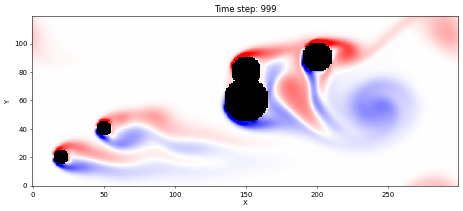

In [12]:
anim(TimePropagation)

### Interpretation of Simulation Results

Upon completion of the simulation, the visualization typically shows the evolution of fluid flow over time, providing insights into various aspects of the simulated phenomenon. Here's what you can observe in the final visualization:

- **Fluid Flow Patterns**: The visualization reveals the spatial distribution of fluid velocities and densities across the computational domain. You can identify flow patterns such as laminar or turbulent flow, vortices, and recirculation zones.

- **Interaction with Boundaries**: The behavior of the fluid near physical boundaries and obstacles becomes evident. You can observe how the fluid interacts with solid surfaces, leading to phenomena such as boundary layers, flow separation, and pressure gradients.

- **Effect of Boundary Conditions**: Different boundary conditions, such as no-slip, slip, or periodic boundaries, can be visualized to understand their impact on fluid flow behavior.

- **Dynamic Phenomena**: If the simulation includes moving boundaries or objects (e.g., a moving ball or changing geometries), you can observe their influence on the fluid flow dynamics over time.

- **Quantitative Analysis**: Besides qualitative observations, the visualization may provide quantitative data such as velocity profiles, pressure distributions, or shear rates, allowing for in-depth analysis of the simulated fluid flow.

By analyzing the simulation results, researchers and engineers can gain valuable insights into the behavior of complex fluid systems and make informed decisions in various applications, ranging from engineering design to environmental modeling.